In [1]:
# インポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
import statsmodels.api as sm
from decimal import Decimal, ROUND_HALF_UP
from sklearn.metrics import mean_squared_error
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from mlxtend.plotting import plot_decision_regions
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# データセット
クラスタリングのための人工データセット
クラスタリングを実験するための人工データセットを作成するコードを用意しています。


このmake_blobs関数は正解ラベルも出力してますが、今回は使用しません。使用しないことを明示するために、 _（アンダースコア） で受け取っています。


《シンプルデータセット3》



In [2]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

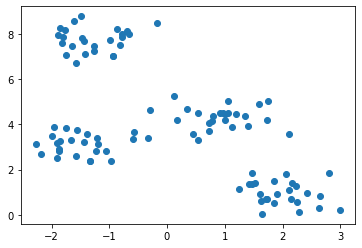

In [3]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [4]:
# 検証用scikit-learn KMeansをインスタンス化
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

In [5]:
kmeans.inertia_

48.63378320706403

# 【問題1】中心点の初期値を決める
入力されたデータから $K$ 個の中心点 $\mu_1$ から $\mu_K$ の初期値を決めるコードを作成してください。$K$ は指定したクラスタ数です。


最もシンプルな初期値の決定方法は、データ点 $X_n$ の中からランダムに $K$ 個選ぶことです。今回はこれを実装してください。


K-meansの学習結果は中心点 $\mu$ の初期値に影響を受けます。そのため、学習時には複数個の初期値で計算を行います。

### 【解答】データからランダムサンプリング

In [6]:
# 初期値をデータからランダムサンプリング
def _centroid_func(X, k=4,used=[], random_seed=None):
    np.random.seed(seed=random_seed)
    if used == []:
        rows, _ = X.shape
        #print(rows)
        centroids = np.random.choice(rows, k, replace=False)
        used.append(centroids)
        return X[centroids]
    
    else:
        rows = X.shape[0] - len(used)
        #print(rows)
        centroids = np.random.choice(rows, k, replace=False)
        array = np.concatenate((used, centroids))
    
        return X[centroids], array


In [7]:
used = []
q1_center = _centroid_func(X,4, used)

### 【可視化】散布図

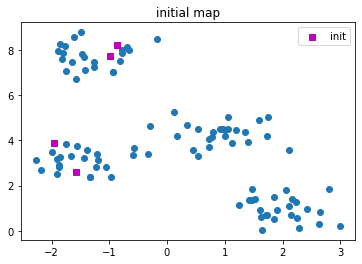

In [8]:
plt.title("initial map")
plt.scatter(X[:,0], X[:,1])
plt.scatter(q1_center[:,0], q1_center[:,1], c="m",  label="init", marker="s")
plt.legend()
plt.show()


# 【問題2】SSEを求める関数の作成
クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。


K-meansはこのSSEを最小化する $r_{nk}$ と $\mu_k$ を求めることが目的となります。複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。

$$
SSE=\Sigma^N_{n=1}\Sigma^K_{k=1} r_{nk}∥X_n−μ_k∥^2
$$


$n$ : データ点のインデックス


$k$ : クラスタのインデックス


$X_n$ : $n$番目のデータ点


$\mu_k$ : $k$番目の中心点


$r_{nk}$ : データ点$X_n$がクラスタ$k$に所属していたら1、そうでなければ0



### 【解答】SSEの計算

In [9]:
used = []
# 初期中心値
q2_C = _centroid_func(X,4, used)
q2_cn = q2_C.shape[0]
#cluster = np.zeros(X.shape[0])
# 初期中心値からの距離を計算した初期クラスタ
q2_cluster = np.array([np.linalg.norm(X-c, axis=1) for c  in q2_C]).argmin(axis=0)
#print(q4_C)

# SSE計算
q2_sse = np.sum([np.sum((X[q2_cluster==i] - q2_C[i])**2)  for i in range(q2_cn)])
print("SSE :{}".format(q2_sse))


SSE :451.70843650776334


## クラスタの割り当てと中心点の移動を繰り返す
K-meansの学習の基本は以下の2つのフェーズを繰り返すことです。


中心点 $\mu_k$ を固定した上で $SSE$ を最小化する クラスタの割り当て $r_{nk}$ を選ぶ。
クラスタの割り当て $r_{nk}$ を固定した上で $SSE$ を最小化する 中心点 $\mu_k$ を選ぶ。

最初の中心点 $\mu_k$ は問題1で作成した初期値です。


順番に見ていきます。


# 【問題3】クラスタへの割り当て
全てのデータ点 $X_n$ を最も近い中心点 $\mu_k$ に割り当てるコードを作成してください。


K-menasにおける 近い とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル $p,q$ に対しては以下の数式で表現できます。

$$
∥q−p∥=√(q−p)⋅(q−p)
$$

NumPyにはこの関数がnp.linalg.normとして用意されているため使用してください。


[numpy.linalg.norm — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html)


中心点 $\mu_k$ を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

### 【解答】クラスタへ割りあて

In [10]:
q3_cluster = np.array([np.linalg.norm(X-c, axis=1) for c  in q2_C]).argmin(axis=0)
print(q3_cluster)


[2 2 2 2 0 2 3 0 2 2 2 2 2 2 2 1 1 3 3 1 0 2 3 1 2 3 3 2 1 1 1 2 1 1 3 2 0
 1 0 3 2 3 2 3 3 2 1 3 2 2 2 1 3 3 3 2 0 1 1 0 2 1 1 0 1 0 3 3 1 2 2 1 2 2
 2 2 3 3 1 1 1 2 3 2 1 3 1 1 0 2 2 3 2 3 3 2 2 3 0 2]


### 【可視化】散布図

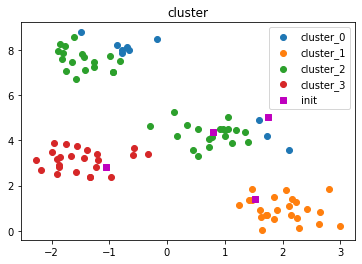

In [11]:
plt.title("cluster")
plt.scatter(X[q3_cluster == 0][:,0], X[q3_cluster == 0][:,1], label="cluster_0")
plt.scatter(X[q3_cluster == 1][:,0], X[q3_cluster == 1][:,1], label="cluster_1")
plt.scatter(X[q3_cluster == 2][:,0], X[q3_cluster == 2][:,1], label="cluster_2")
plt.scatter(X[q3_cluster == 3][:,0], X[q3_cluster == 3][:,1], label="cluster_3")
plt.scatter(q2_C[:,0], q2_C[:,1], c="m",  label="init", marker="s")
plt.legend()
plt.show()


# 【問題4】中心点の移動
中心点 $\mu_k$ を $k$ 番目のクラスタに割り当てられる全てのデータ点 $X_n$ の平均値（重心）に移動するコードを作成してください。


クラスタの割り当て $r_{nk}$ を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

### 【解答】一回分移動する

[[ 2.79939362  1.84560825]
 [-1.95751686  3.87291474]
 [ 2.23345072  1.25095024]
 [-1.74448079  3.84251413]]
4
[3 1 0 3 0 3 1 3 3 1 3 1 3 3 3 2 2 3 3 2 0 1 3 2 3 3 3 3 0 2 2 3 2 2 3 0 1
 2 3 3 3 3 1 1 3 1 2 3 3 3 3 2 3 3 3 3 3 2 2 3 1 2 2 0 2 3 1 3 2 3 1 2 3 1
 3 0 3 3 2 2 2 1 3 3 2 3 2 2 0 3 3 3 3 3 1 1 1 3 3 3]


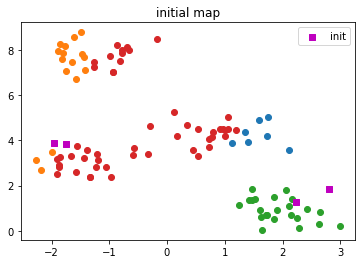

cog:[[ 1.73325085  3.96761675]
 [-1.7623244   6.73221269]
 [ 1.95822217  0.92894415]
 [-0.52253607  4.62352543]]
クラスタ:[0 1 0 0 0 0 3 1 3 1 1 1 1 1 1 2 2 3 3 2 0 1 3 2 3 3 3 0 2 2 2 1 2 2 3 0 1
 2 1 3 0 3 1 3 3 1 2 3 0 0 3 2 3 3 3 1 1 2 2 1 1 2 2 0 2 1 3 3 2 0 1 2 0 1
 0 0 3 3 2 2 2 1 3 3 2 3 2 2 0 0 0 3 0 3 3 1 1 3 1 3]


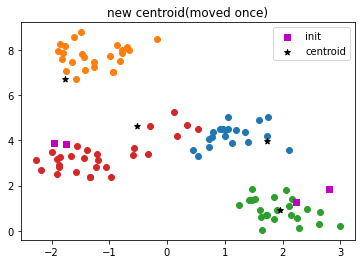

In [12]:
used = []
# 初期中心値
q4_C = _centroid_func(X,4, used)
q4_cn = q4_C.shape[0]
#cluster = np.zeros(X.shape[0])
# 初期中心値からの距離を計算した初期クラスタ
q4_cluster = np.array([np.linalg.norm(X-c, axis=1) for c  in q4_C]).argmin(axis=0)
print(q4_C)
print(q4_cn)
print(q4_cluster)

plt.title("initial map")
plt.scatter(X[q4_cluster == 0][:,0], X[q4_cluster == 0][:,1])
plt.scatter(X[q4_cluster == 1][:,0], X[q4_cluster == 1][:,1])
plt.scatter(X[q4_cluster == 2][:,0], X[q4_cluster == 2][:,1])
plt.scatter(X[q4_cluster == 3][:,0], X[q4_cluster == 3][:,1])
plt.scatter(q4_C[:,0], q4_C[:,1], c="m",  label="init", marker="s")
plt.legend()
plt.show()


q4_C = q4_C
tol = 1



# クラスタごとの平均をとって重心を計算
q4_cog = np.array([X[q4_cluster==i].mean(axis=0) for i in range(q4_cn)])
print("cog:{}".format(q4_cog))
# 重心からの距離を計算した新クラスタ
q4_new_cluster = np.array([np.linalg.norm(X-c, axis=1) for c  in q4_cog]).argmin(axis=0)
print("クラスタ:{}".format(q4_new_cluster))


    


plt.title("new centroid(moved once)")
plt.scatter(X[q4_new_cluster == 0][:,0], X[q4_new_cluster == 0][:,1])
plt.scatter(X[q4_new_cluster == 1][:,0], X[q4_new_cluster == 1][:,1])
plt.scatter(X[q4_new_cluster == 2][:,0], X[q4_new_cluster == 2][:,1])
plt.scatter(X[q4_new_cluster == 3][:,0], X[q4_new_cluster == 3][:,1])
plt.scatter(q4_C[:,0], q4_C[:,1], c="m",  label="init", marker="s")
plt.scatter(q4_cog[:,0], q4_cog[:,1], c="k", label='centroid', marker="*")
#plt.plot(plot_line)
plt.legend()
plt.show()



# 【問題5】繰り返し
クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。


次のどれかの条件を満たしたらこれを止めます。


繰り返しが指定した回数に到達する。（雛形では引数max_iter）
中心点 $\mu_k$ と重心の差の合計が指定した許容値以下になる。（雛形では引数tol）

### 【解答】max_iter回分、または終了条件を満たすまでforループ

初期配置:[[-0.59312453  3.37090459]
 [ 0.96217896  4.51795326]
 [-0.78782636  7.99482384]
 [ 0.72144399  4.08475018]]
初期配置から算出した初期クラスタ :[3 2 1 1 1 3 0 2 1 2 2 2 2 2 2 3 3 0 0 3 3 2 0 3 1 0 0 1 3 3 3 2 3 3 0 3 2
 3 2 0 1 0 2 0 0 2 0 0 3 3 1 3 0 0 0 2 2 3 3 2 2 3 3 1 3 2 0 0 3 1 2 3 1 2
 3 3 0 0 3 0 0 2 0 3 3 0 3 3 1 1 1 0 3 0 0 2 2 0 2 3]


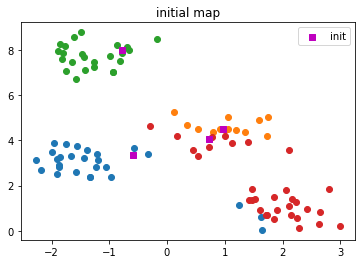

cog:[[-1.15982815  2.84646571]
 [ 1.02961696  4.63119037]
 [-1.26811733  7.76378266]
 [ 1.63690813  1.9894162 ]]
クラスタ:[1 2 1 1 1 1 0 2 1 2 2 2 2 2 2 3 3 0 0 3 1 2 0 3 1 0 0 1 3 3 3 2 3 3 0 1 2
 3 2 0 1 0 2 0 0 2 3 0 1 1 1 3 0 0 0 2 2 3 3 2 2 3 3 1 3 2 0 0 3 1 2 3 1 2
 1 1 0 0 3 3 3 2 0 1 3 0 3 3 1 1 1 0 1 0 0 2 2 0 2 1]
False
cog:[[-1.15982815  2.84646571]
 [ 1.02961696  4.63119037]
 [-1.26811733  7.76378266]
 [ 1.63690813  1.9894162 ]]
クラスタ:[1 2 1 1 1 1 0 2 1 2 2 2 2 2 2 3 3 0 0 3 1 2 0 3 1 0 0 1 3 3 3 2 3 3 0 1 2
 3 2 0 1 0 2 0 0 2 3 0 1 1 1 3 0 0 0 2 2 3 3 2 2 3 3 1 3 2 0 0 3 1 2 3 1 2
 1 1 0 0 3 3 3 2 0 1 3 0 3 3 1 1 1 0 1 0 0 2 2 0 2 1]
True
break: iter: 1


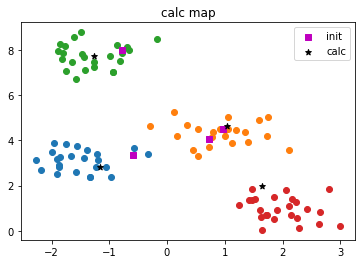

SSE :84.98967720357965


In [13]:
used = []
# 初期中心値
init_C = _centroid_func(X,4, used)
cn = init_C.shape[0]
#cluster = np.zeros(X.shape[0])
# 初期中心値からの距離を計算した初期クラスタ
init_cluster = np.array([np.linalg.norm(X-c, axis=1) for c  in init_C]).argmin(axis=0)
print("初期配置:{}".format(init_C))
print("初期配置から算出した初期クラスタ :{}".format(init_cluster))

for i in range(cn):
    plt.scatter(X[init_cluster == i][:,0], X[init_cluster == i][:,1])
plt.title("initial map")
plt.scatter(init_C[:,0], init_C[:,1], c="m",  label="init", marker="s")
#plt.scatter(cog[:,0], cog[:,1], c="k", label='calc', marker="^")
plt.legend()
plt.show()



# 途中計算用に複製
C = init_C

# 終了条件
tol = 0.01

for j in range(10):
    # クラスタごとの平均をとって重心を計算
    cog = np.array([X[init_cluster==i].mean(axis=0) for i in range(cn)])
    print("cog:{}".format(cog))
    # 重心からの距離を計算した新クラスタ
    new_cluster_001 = np.array([np.linalg.norm(X - c, axis=1) for c  in cog]).argmin(axis=0)
    print("クラスタ:{}".format(new_cluster_001))
    
    # 最初の中心とクラスタ平均による重心の差異を計算し、tolより下回っていたら終わり
    print(np.allclose(C, cog, atol=tol))
    if np.allclose(C, cog, atol=tol):
        print("break: iter: {}".format(j))
        break
    
    #中心の情報を保存
    C = cog
    
#print(cog)

for i in range(cn):
    plt.scatter(X[new_cluster_001 == i][:,0], X[new_cluster_001 == i][:,1])
plt.title("calc map")
plt.scatter(init_C[:,0], init_C[:,1], c="m",  label="init", marker="s")
plt.scatter(cog[:,0], cog[:,1], c="k", label='calc', marker="*")
plt.legend()
plt.show()


# SSE計算
sse = np.sum([np.sum((X[new_cluster_001==i] - cog[i])**2)  for i in range(cn)])
print("SSE :{}".format(sse))

#print([np.sum((X[new_cluster_001==i] - cog[i])**2)  for i in range(cn)])

In [14]:
# 次から使う用にXを分割
X_train, X_test= train_test_split( X, train_size=0.7, random_state=50)

# 【問題6】異なる初期値で計算
問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。回数は雛形では引数n_initで指定します。


複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点 $\mu_k$ を保持しておきます。



### 【解答】

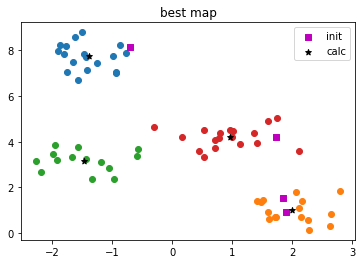

In [15]:

n_init = 10
k = 4

# 終了条件
tol = 1
min_sse = 1000


used = []
random_seed = None
rows, _ = X_train.shape

for i in range(n_init):
    np.random.seed(seed=random_seed)
    # 初期中心値
    centroids = np.random.choice(rows, k, replace=False)
    init_C = X_train[centroids]
    used = np.concatenate((used, centroids))
    #print(used)
    
    cn = init_C.shape[0]
    init_cluster = np.array([np.linalg.norm(X_train-c, axis=1) for c  in init_C]).argmin(axis=0)
    
    C = init_C
    
    for j in range(10):
        # クラスタごとの平均をとって重心を計算
        cog = np.array([X_train[init_cluster==i].mean(axis=0) for i in range(cn)])
        #print("cog:{}".format(cog))
        # 重心からの距離を計算した新クラスタ
        new_cluster_001 = np.array([np.linalg.norm(X_train - c, axis=1) for c  in cog]).argmin(axis=0)
        #print("クラスタ:{}".format(new_cluster_001))

        # 最初の中心とクラスタ平均による重心の差異を計算し、tolより下回っていたら終わり
        #print(np.allclose(C, cog))
        if np.allclose(C, cog):
            #print("break: iter: {}".format(j))
            break

        #中心の情報を保存
        C = cog
        init_cluster = new_cluster_001
    
    # SSE計算
    sse = np.sum([np.sum((X_train[new_cluster_001==i] - cog[i])**2)  for i in range(cn)])
    #print("SSE :{}".format(sse))
    
    if min_sse > sse:
        best_centroid = cog
        min_sse = sse
        #print("best_sse:{}".format(sse))
        #print("best_centroid:{}".format(best_centroid))
        
    
#print(cog)

best_cluster = np.array([np.linalg.norm(X_train - c, axis=1) for c  in best_centroid]).argmin(axis=0)
#print(best_cluster)


for i in range(cn):
    plt.scatter(X_train[best_cluster == i][:,0], X_train[best_cluster == i][:,1])
plt.title("best map")
plt.scatter(init_C[:,0], init_C[:,1], c="m",  label="init", marker="s")
plt.scatter(best_centroid[:,0], best_centroid[:,1], c="k", label='calc', marker="*")
plt.legend()
plt.show()




#print([np.sum((X[new_cluster_001==i] - cog[i])**2)  for i in range(cn)])

# 【問題7】推定
新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。


データ点 $X_n$ と学習で決まった中心点 $\mu_k$ に対し、 $SSE$ を最小化する $r_{nk}$ を選ぶ。

具体的には次のことです。


データ点 $X_n$ を最も近い $\mu_k$ に割り当てる。

### 【解答】predict関数

In [16]:
# 推定関数
def predict(X, centroid):
    pred = np.array([np.linalg.norm(X - c, axis=1) for c  in centroid]).argmin(axis=0)
    
    return pred

pred = predict(X_test, best_centroid)    
pred

array([1, 1, 2, 1, 2, 3, 2, 2, 1, 3, 2, 3, 1, 1, 2, 3, 0, 2, 3, 2, 2, 3,
       0, 2, 0, 0, 0, 0, 1, 2])

### 【可視化】

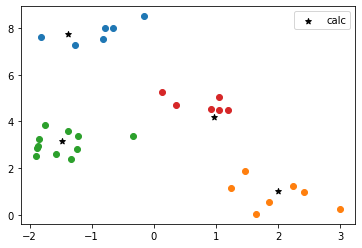

In [17]:
# 推定可視化

for i in range(cn):
    plt.scatter(X_test[pred == i][:,0], X_test[pred == i][:,1])
#plt.scatter(init_C[:,0], init_C[:,1], c="m",  label="init", marker="s")
plt.scatter(best_centroid[:,0], best_centroid[:,1], c="k", label='calc', marker="*")
plt.legend()
plt.show()


# 【問題8】エルボー法の実装
K-meansにおいて中心点の個数 $k$ は人為的に決める必要がありますが、その判断方法としてエルボー法があります。エルボー法により中心点の個数 $k$ を検討するためのコードを作成してください。


SSEを縦軸、クラスタ数 $k$ を横軸にした折れ線グラフを表示します。このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

### 【解答】さらに外側にforを追加

In [18]:
SSE =[]

for i in range(1,11):
    
    n_init = 10
    k = i

    # 終了条件
    tol = 1
    min_sse = 1000


    used = []
    random_seed = None
    rows, _ = X_train.shape

    for i in range(n_init):
        np.random.seed(seed=random_seed)
        # 初期中心値
        centroids = np.random.choice(rows, k, replace=False)
        init_C = X_train[centroids]
        used = np.concatenate((used, centroids))

        cn = init_C.shape[0]
        init_cluster = np.array([np.linalg.norm(X_train-c, axis=1) for c  in init_C]).argmin(axis=0)

        C = init_C

        for j in range(10):
            # クラスタごとの平均をとって重心を計算
            cog = np.array([X_train[init_cluster==i].mean(axis=0) for i in range(cn)])
            #print("cog:{}".format(cog))
            # 重心からの距離を計算した新クラスタ
            new_cluster_001 = np.array([np.linalg.norm(X_train - c, axis=1) for c  in cog]).argmin(axis=0)
            #print("クラスタ:{}".format(new_cluster_001))

            # 最初の中心とクラスタ平均による重心の差異を計算し、tolより下回っていたら終わり
            #print(np.allclose(C, cog, atol=tol))
            if np.allclose(C, cog, atol=tol):
                #print("break: iter: {}".format(j))
                break

            #中心の情報を保存
            C = cog

        # SSE計算
        sse = np.sum([np.sum((X_train[new_cluster_001==i] - cog[i])**2)  for i in range(cn)])
        #print("SSE :{}".format(sse))

        if min_sse > sse:
            best_centroid = cog
            min_sse = sse
            #print("best_sse:{}".format(sse))
            #print("best_centroid:{}".format(best_centroid))


    SSE.append(min_sse)

print(SSE)

[625.228422606358, 227.1071220860132, 94.19051164129368, 32.65995550575954, 30.156743147689642, 28.03228773764443, 21.567419854488982, 19.806214542377138, 18.259945913663604, 17.66500315021143]


### 【可視化】エルボー法可視化

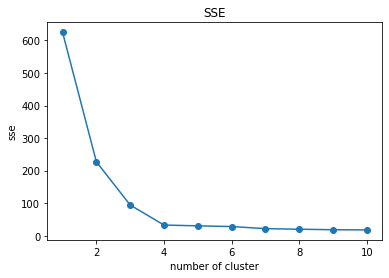

In [19]:
plt.title("SSE")
plt.xlabel("number of cluster")
plt.ylabel("sse")
plt.plot(range(1,11),SSE,marker = "o")
plt.show()

# 【問題9】（アドバンス課題）シルエット図
$k$ を決める助けになるものとしてシルエット図もあります。シルエット図を表示するコードを作成してください。


Matplotlibを使い図を表示するコードは用意しました。以下を与えてください。


silhouette_vals : shape(n_samples,)のndarray、各データ点のシルエット係数


silhouette_avg : float、シルエット係数の平均値


y_km : shape(n_samples,)のndarray、各データ点のクラスタラベル名


cluster_labels : list、クラスタのラベル名のリスト


n_clusters : int、クラスタ数


$n$ 番目のデータ点に対するシルエット係数 $s_n$ は以下の数式でを求められます。この数式を実装し、シルエット図を確認してください。

$$
s_n=\frac{b_n - a_n}{ max(b_n,a_n)}
$$

$a_n$ : 凝集度。同じクラスタ内の他のデータ点との距離の平均値。


$b_n$ : 乖離度。最も近い他のクラスタ内の全てのデータ点との距離の平均値。


乖離度 $b$ が大きく、凝集度 $a$ が小さい時が理想的であり、シルエット係数 $s$ は1に近くなります。


《シルエット図を表示するためのコード》

In [20]:
"""
# 雛形
from matplotlib import cm
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()
"""

'\n# 雛形\nfrom matplotlib import cm\ny_ax_lower, y_ax_upper = 0, 0\nyticks = []\nfor i, c in enumerate(cluster_labels):\n    c_silhouette_vals = silhouette_vals[y_km == c]\n    c_silhouette_vals.sort()\n    y_ax_upper += len(c_silhouette_vals)\n    color = cm.jet(i / n_clusters)\n    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor=\'none\', color=color)\n    yticks.append((y_ax_lower + y_ax_upper) / 2)\n    y_ax_lower += len(c_silhouette_vals)\nplt.axvline(silhouette_avg, color="red", linestyle="--")\nplt.yticks(yticks, cluster_labels + 1)\nplt.ylabel(\'Cluster\')\nplt.xlabel(\'Silhouette coefficient\')\nplt.show()\n'

### 【解答】シルエット係数の計算と可視化

In [21]:
def calc_silhouette(data, clusters):
    # クラスタリングのシルエット係数の計算
    n = len(data)
    num_clusters = len(np.unique(clusters))
    cl_ids = []
    centroids = []
    
    for c in range(num_clusters):
        ids = np.where(clusters == c)[0]
        cl_ids.append(ids)
        centroids.append(np.average(data[ids], axis=0))
    
    silhouette = np.zeros(n)
    
    for c in range(num_clusters):
        for i in cl_ids[c]:
            nearest_clusters = np.argsort(np.sum((data[i] - centroids)**2, axis=1))
            c_nearest = nearest_clusters[1] if nearest_clusters[0]==c else nearest_clusters[0]
            a = np.sum(np.sqrt(np.sum((data[i]-data[cl_ids[c]])**2, axis=1))) / (len(cl_ids[c])-1)
            b = np.average(np.sqrt(np.sum((data[i]-data[cl_ids[c_nearest]])**2, axis=1)))
            silhouette[i] = (b-a) / max(a, b)
    
    return silhouette


def plot_silhouette(data, clusters):
    # シルエット係数の計算・描画
    cl_size = {}
    
    for c in np.unique(clusters):
        cl_size[c] = np.count_nonzero(clusters == c)
    silhouette = calc_silhouette(data, clusters)
    silhouette_ave = np.average(silhouette)
    ids_sorted = np.lexsort((silhouette, clusters))
    data_sorted = data[ids_sorted]
    silhouette_sorted = silhouette[ids_sorted]        
    
    plt.figure(figsize=(12,4))
    # クラスタの描画
    plt.subplot(1, 2, 1)
    plt.title("clusters")
    start = 0
    for c in range(len(cl_size)):
        plt.scatter(data_sorted[start:start+cl_size[c], 0], data_sorted[start:start+cl_size[c], 1], s=20, label="cluster {}".format(c+1))
        start += cl_size[c]
    plt.legend(loc="upper left")
    # シルエット図の描画
    plt.subplot(1, 2, 2)
    plt.title("Silhouette")
    plt.xlabel("Silhouette Coeficient")
    plt.ylabel("Number of data")
    plt.axvline(silhouette_ave, c='k', linestyle='dashed', label='average={:.3f}'.format(silhouette_ave))
    start = 0
    for c in range(len(cl_size)):
        plt.barh(range(start, start+cl_size[c]), silhouette_sorted[start:start+cl_size[c]], height=1.0, label='cluster {}'.format(c+1))
        start += cl_size[c]
    plt.legend(loc='upper left')
    plt.show()

    

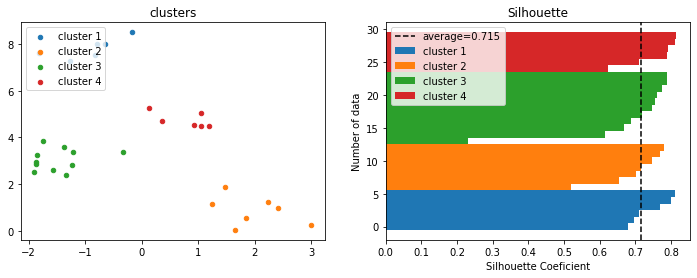

In [22]:
plot_silhouette(X_test, pred)

ここまでをクラスにまとめる

In [23]:
# クラスの清書
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, n_clusters, n_init=10, max_iter=10, tol=1e-8, NK=10, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol  = tol
        self.verbose = verbose
        self.init_sse = None
        self.NK = NK
        
    
    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """        
        self.used_list=[]
        best_centroid = np.zeros((self.n_clusters,))
        
        min_sse = 1000
        
        for i in range(self.n_init):
            # ここのforで初期配置をランダムサンプリング
            init_centroids = self._centroid_func(X, self.n_clusters)
            init_cluster = self._cluster_calc(X, init_centroids)
            
            #print(init_centroids)
            #print(init_cluster)

            tmp_c = init_centroids
            
            for j in range(self.max_iter):
                # 一個前のクラスタごとの平均をとって重心を計算
                center_of_gravity = np.array([X[init_cluster==i].mean(axis=0) for i in range(self.n_clusters)])
                #print(center_of_gravity)
                
                # 計算した重心からの距離を計算した新クラスタ
                new_cluster = np.array([np.linalg.norm(X - c, axis=1) for c  in center_of_gravity]).argmin(axis=0)
                #print(new_cluster)

                # 一個前の中心とクラスタ平均による重心の差異を計算し、tolより下回っていたら終わり
                #print(np.allclose(tmp_c, center_of_gravity, atol=self.tol))
                if np.allclose(tmp_c, center_of_gravity, atol=self.tol):
                    #print("break: iter: {}".format(j))
                    break
                
                # 中心の情報を保存
                tmp_c = center_of_gravity
                init_cluster = new_cluster

            # SSE計算
            sse = self._sse_func(X, center_of_gravity, new_cluster)
            #print("SSE :{}".format(sse))

            if min_sse > sse:
                best_centroid = center_of_gravity
                min_sse = sse
                #print("best_sse:{}".format(min_sse))
                #print("best_centroid:{}".format(best_centroid))
        
            if self.verbose == True:
            #verboseをTrueにした際は学習過程を出力
                print("n_init:{}回目".format(i))
                print("初期配置:{}".format(init_centroids))
                print("best centroids:{}".format(best_centroid))
                print("SSE:{}".format(sse))
                print("best_SSE:{}".format(min_sse))
        
        self.init_sse = min_sse
        self.best_centroid = best_centroid
    
    # 問題１
    def _centroid_func(self, X, k , random_seed=0):
        np.random.seed(seed=random_seed)
        rows = X.shape[0] - len(self.used_list)
        centroids = np.random.choice(rows, k, replace=False)
        self.used_list = np.concatenate((self.used_list, centroids))
        return X[centroids]
        
    # 問題2
    def _sse_func(self, X, centroids, clusters):
        return np.sum([np.sum((X[clusters==i] - centroids[i])**2)  for i in range(self.n_clusters)])
    
    # 問題3
    def _cluster_calc(self, X, centroids):
        return np.array([np.linalg.norm(X-c, axis=1) for c  in centroids]).argmin(axis=0)
    
    
    def elbow_func(self, X):
        SSE_list = []
        for i in range(1, self.NK):
            self.n_clusters = i
            self.fit(X)
            SSE_list.append(self.init_sse)        
        self.plot_elbow(SSE_list)
    
    def plot_elbow(self, SSE_list):
        plt.title("Elbow")
        plt.xlabel("number of cluster")
        plt.ylabel("sse")
        plt.plot(range(1, self.NK),SSE_list, marker = "o")
        plt.show()
    
    def calc_silhouette(self, data, clusters):
        # クラスタリングのシルエット係数の計算
        n = len(data)
        num_clusters = len(np.unique(clusters))
        cl_ids = []
        centroids = []

        for c in range(num_clusters):
            ids = np.where(clusters == c)[0]
            cl_ids.append(ids)
            centroids.append(np.average(data[ids], axis=0))

        silhouette = np.zeros(n)

        for c in range(num_clusters):
            for i in cl_ids[c]:
                nearest_clusters = np.argsort(np.sum((data[i] - centroids)**2, axis=1))
                c_nearest = nearest_clusters[1] if nearest_clusters[0]==c else nearest_clusters[0]
                a = np.sum(np.sqrt(np.sum((data[i]-data[cl_ids[c]])**2, axis=1))) / (len(cl_ids[c])-1)
                b = np.average(np.sqrt(np.sum((data[i]-data[cl_ids[c_nearest]])**2, axis=1)))
                silhouette[i] = (b-a) / max(a, b)

        return silhouette


    def plot_silhouette(self, data, clusters):
        # シルエット係数の計算・描画
        cl_size = {}

        for c in np.unique(clusters):
            cl_size[c] = np.count_nonzero(clusters == c)
        silhouette = calc_silhouette(data, clusters)
        silhouette_ave = np.average(silhouette)
        ids_sorted = np.lexsort((silhouette, clusters))
        data_sorted = data[ids_sorted]
        silhouette_sorted = silhouette[ids_sorted]
        
        #print(data_sorted)
        #print(ids_sorted)
        #print(silhouette_sorted)
        
        

        plt.figure(figsize=(12,4))
        # クラスタの描画
        plt.subplot(1, 2, 1)
        plt.title("clusters")
        start = 0            
        for c in range(len(cl_size)):
            plt.scatter(data_sorted[start:start+cl_size[c], 0], data_sorted[start:start+cl_size[c], 1], s=20, label="cluster {}".format(c+1))
            start += cl_size[c]
        plt.legend()
        # シルエット図の描画
        plt.subplot(1, 2, 2)
        plt.title("Silhouette")
        plt.xlabel("Silhouette Coeficient")
        plt.ylabel("Number of data")
        plt.axvline(silhouette_ave, c='k', linestyle='dashed', label='average={:.3f}'.format(silhouette_ave))
        start = 0
        for c in range(len(cl_size)):
            plt.barh(range(start, start+cl_size[c]), silhouette_sorted[start:start+cl_size[c]], height=1.0, label='cluster {}'.format(c+1))
            start += cl_size[c]
        plt.legend(loc='upper left')
        plt.show()


    
    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        pred = np.array([np.linalg.norm(X - c, axis=1) for c  in self.best_centroid]).argmin(axis=0)
        return pred

In [24]:
tmp = ScratchKMeans(n_clusters=4, n_init=10 , max_iter=10, tol=1e-8, NK=8, verbose=False)

In [25]:
tmp.fit(X_train)


In [26]:
label_pred = tmp.predict(X_test)
label_pred

array([1, 1, 2, 1, 2, 3, 2, 2, 1, 3, 2, 3, 1, 1, 2, 3, 0, 2, 3, 2, 2, 3,
       0, 2, 0, 0, 0, 0, 1, 2])

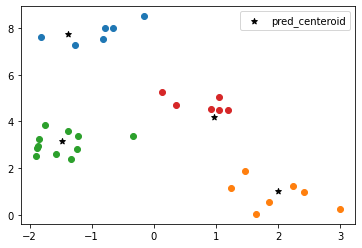

In [27]:
# 推定可視化

for i in range(4):
    plt.scatter(X_test[label_pred == i][:,0], X_test[label_pred == i][:,1])
#plt.scatter(init_C[:,0], init_C[:,1], c="m",  label="init", marker="s")
plt.scatter(tmp.best_centroid[:,0], tmp.best_centroid[:,1], c="k", label='pred_centeroid', marker="*")
plt.legend()
plt.show()


/Users/kouta/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice.
/Users/kouta/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


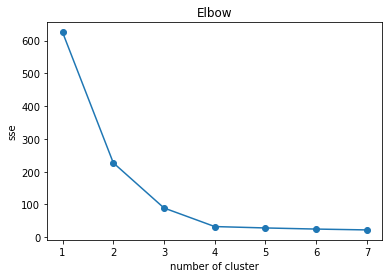

In [28]:
# エルボー法
tmp.elbow_func(X_train)

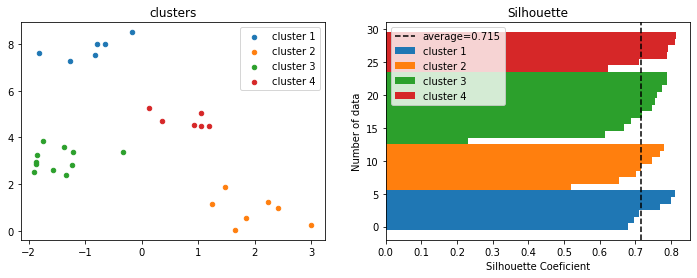

In [29]:
# シルエット判定
tmp.plot_silhouette(X_test, label_pred)

## 卸売業者のデータ分析
クラスタリングを利用法を学ぶために、Wholesale customers Data Setを使用します。


[UCI Machine Learning Repository: Wholesale customers Data Set](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)


Data Folderの中からWholesale customers data.csvをダウンロードしてください。これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。顧客は小売店やレストランです。RegionとChannelは取り覗き、金額のデータでK-meansを利用します。

### データ概観

In [30]:
# データ読み込み
raw_data = pd.read_csv("Wholesale customers data.csv")
display(raw_data)
data = raw_data.drop(["Channel", "Region"], axis=1)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


* Channel : 小売店の形態、1=HoReCa。食品サービス業界。Hotel/Restaurant/Cafeの略称、2=その他 
* Region ：消費地域 - 1=リスボン、2=ポルト、3=その他
* Fresh  ：生鮮品の年間支出（通貨単位）
* Milk  ：乳製品の年間支出（通貨単位）
* Grocery：食料品の年間支出（通貨単位）
* Frozen ：冷凍品の年間支出（通貨単位）
* Detergents_Paper：洗剤、紙製品の年間支出（通貨単位）
* Delicassen：デリカテッセン(惣菜)の年間支出（通貨単位）

欠損値なし、カテゴリカル変数なし。

In [31]:
# Channel==1のデータ
data[raw_data.Channel == 1].describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,13475.560403,3451.724832,3962.137584,3748.251678,790.560403,1415.956376
std,13831.687502,4352.165571,3545.513391,5643.912500,1104.093673,3147.426922
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,4070.250000,1164.500000,1703.750000,830.000000,183.250000,379.000000
50%,9581.500000,2157.000000,2684.000000,2057.500000,385.500000,821.000000
75%,18274.750000,4029.500000,5076.750000,4558.750000,899.500000,1548.000000
max,112151.000000,43950.000000,21042.000000,60869.000000,6907.000000,47943.000000


In [32]:
# Channel==2のデータ
data[raw_data.Channel == 2].describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
mean,8904.323944,10716.500000,16322.852113,1652.612676,7269.507042,1753.436620
std,8987.714750,9679.631351,12267.318094,1812.803662,6291.089697,1953.797047
min,18.000000,928.000000,2743.000000,33.000000,332.000000,3.000000
25%,2347.750000,5938.000000,9245.250000,534.250000,3683.500000,566.750000
50%,5993.500000,7812.000000,12390.000000,1081.000000,5614.500000,1350.000000
75%,12229.750000,12162.750000,20183.500000,2146.750000,8662.500000,2156.000000
max,44466.000000,73498.000000,92780.000000,11559.000000,40827.000000,16523.000000


In [33]:
# Region==1のデータ
data[raw_data.Region == 1].describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,11101.727273,5486.415584,7403.077922,3000.337662,2651.116883,1354.896104
std,11557.438575,5704.856079,8496.287728,3092.143894,4208.462708,1345.423340
min,18.000000,258.000000,489.000000,61.000000,5.000000,7.000000
25%,2806.000000,1372.000000,2046.000000,950.000000,284.000000,548.000000
50%,7363.000000,3748.000000,3838.000000,1801.000000,737.000000,806.000000
75%,15218.000000,7503.000000,9490.000000,4324.000000,3593.000000,1775.000000
max,56083.000000,28326.000000,39694.000000,18711.000000,19410.000000,6854.000000


In [34]:
# Region==2のデータ
data[raw_data.Region == 2].describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,9887.680851,5088.170213,9218.595745,4045.361702,3687.468085,1159.702128
std,8387.899211,5826.343145,10842.745314,9151.784954,6514.717668,1050.739841
min,3.000000,333.000000,1330.000000,131.000000,15.000000,51.000000
25%,2751.500000,1430.500000,2792.500000,811.500000,282.500000,540.500000
50%,8090.000000,2374.000000,6114.000000,1455.000000,811.000000,898.000000
75%,14925.500000,5772.500000,11758.500000,3272.000000,4324.500000,1538.500000
max,32717.000000,25071.000000,67298.000000,60869.000000,38102.000000,5609.000000


In [35]:
# Region==3のデータ
data[raw_data.Region == 3].describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000
mean,12533.471519,5977.085443,7896.363924,2944.594937,2817.753165,1620.601266
std,13389.213115,7935.463443,9537.287778,4260.126243,4593.051613,3232.581660
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3350.750000,1634.000000,2141.500000,664.750000,251.250000,402.000000
50%,8752.500000,3684.500000,4732.000000,1498.000000,856.000000,994.000000
75%,17406.500000,7198.750000,10559.750000,3354.750000,3875.750000,1832.750000
max,112151.000000,73498.000000,92780.000000,36534.000000,40827.000000,47943.000000


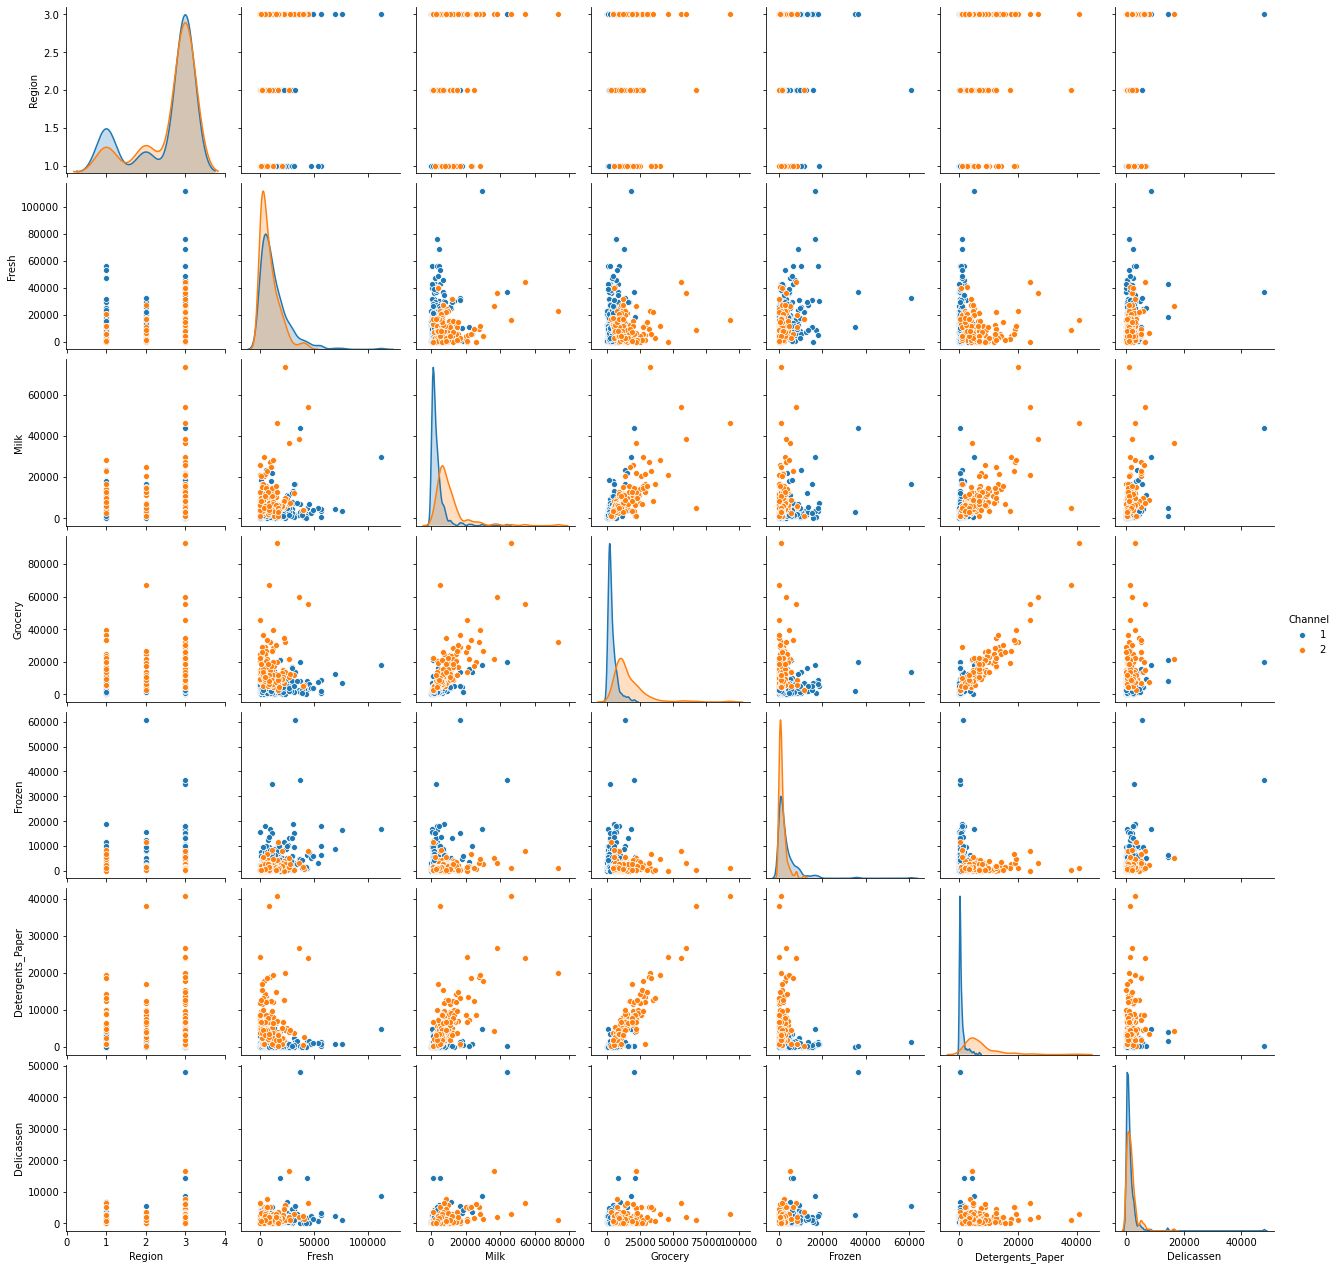

In [36]:
# Channelを基準としたペアプロット
sns.pairplot(raw_data, hue="Channel", height=2.5)
plt.show()

/Users/kouta/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


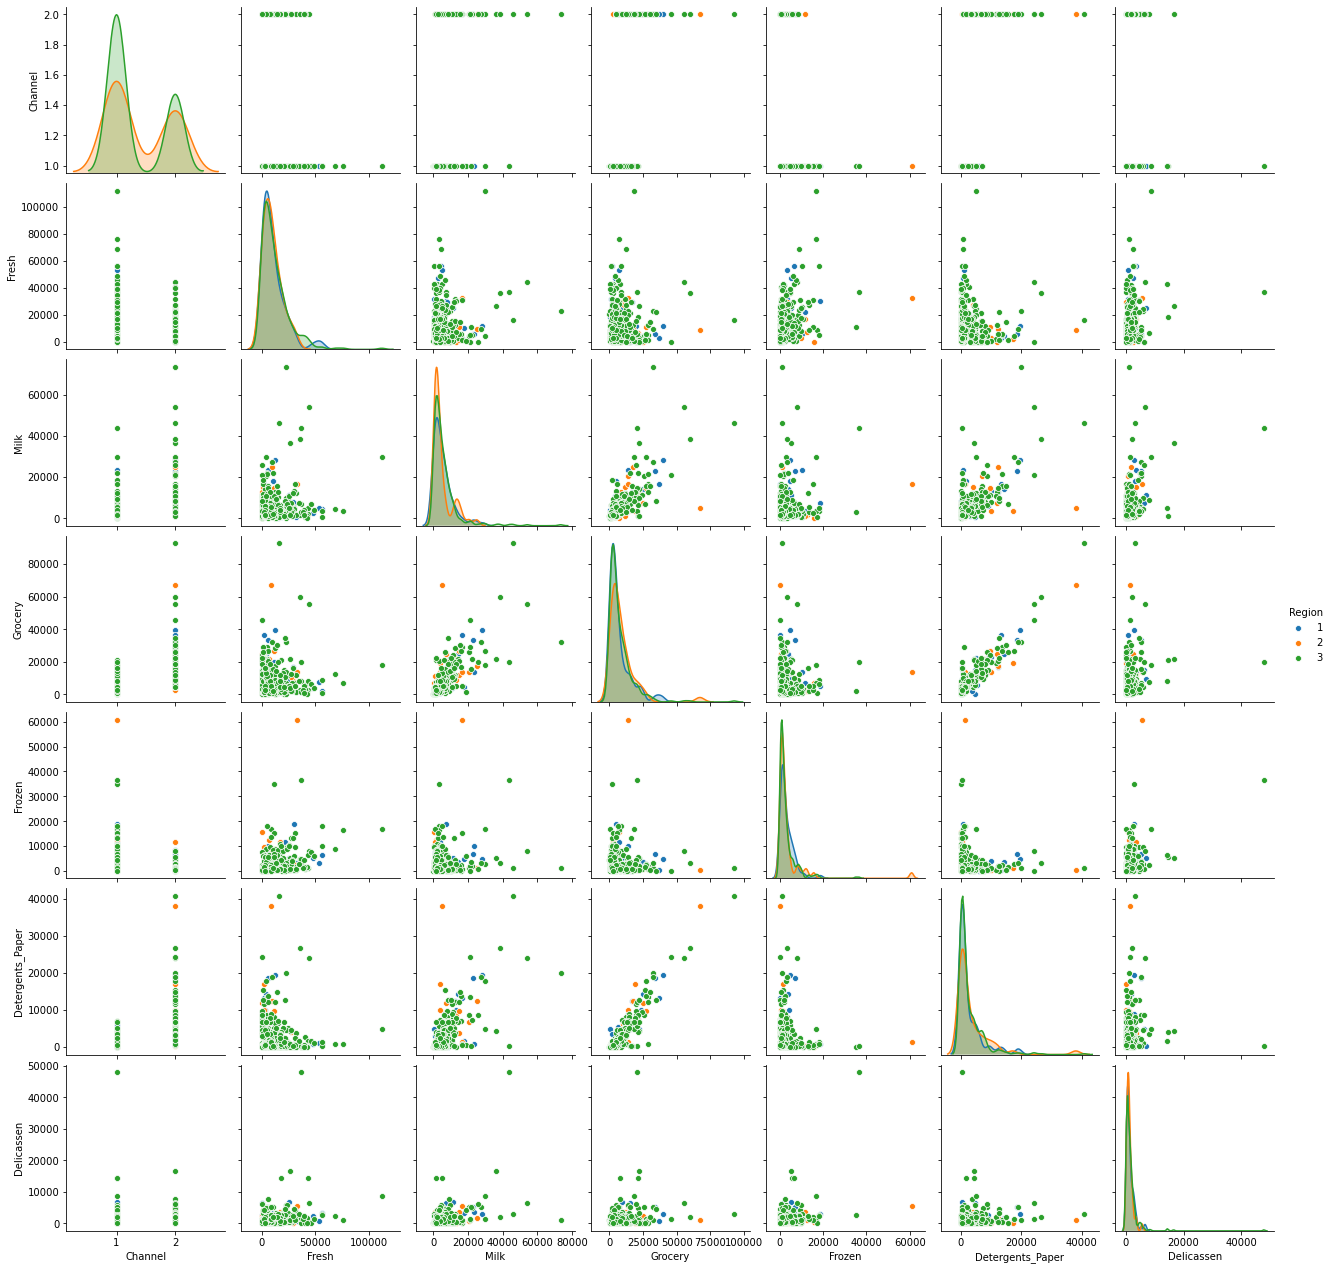

In [37]:
# Regionを基準としたペアプロット
sns.pairplot(raw_data, hue="Region", height=2.5)
plt.show()

## 次元削減
金額に関する特徴量は6個ありますが、可視化するために次元削減を行います。これに関してはscikit-learnによるPCAのサンプルコードを用意したので利用してください。


《PCAのサンプルコード》

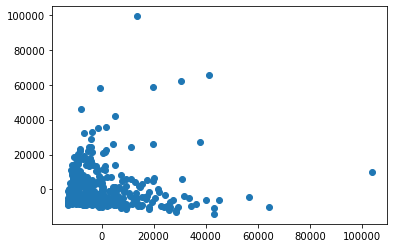

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)
data_pca

plt.scatter(data_pca[:,0], data_pca[:,1])
plt.show()

《PCAの分散説明率を表示するコードサンプル》

[0.45961362 0.86478588 0.93481597 0.97883941 0.99386152 1.        ]


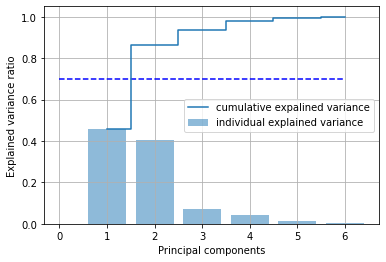

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

# 【問題10】クラスタ数kの選択
最適だと思われるクラスタ数 $k$ を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。

In [40]:
# 標準化
sc = StandardScaler()
sc.fit(data_pca)

data_pca_std = sc.transform(data_pca)

In [41]:
data_train, data_test= train_test_split(data_pca_std, train_size=0.7, random_state=10)

In [42]:
q10 = ScratchKMeans(n_clusters=6, n_init=10 , max_iter=50, tol=0.1, NK=16, verbose=False)

In [43]:
q10.fit(data_pca_std)
q10.best_centroid

array([[ 1.13306214,  5.12306113],
       [ 0.55533579, -0.42305594],
       [-0.58011364,  0.40638257],
       [-0.53507906, -0.48286988],
       [-0.29342304,  1.64655295],
       [ 2.67315618, -0.37394818]])

In [44]:
q10_pred = q10.predict(data_pca_std)
q10_pred

array([2, 2, 2, 1, 1, 3, 3, 2, 3, 4, 2, 3, 1, 1, 1, 3, 2, 3, 1, 2, 1, 3,
       1, 4, 1, 1, 3, 1, 4, 5, 1, 3, 1, 1, 3, 2, 1, 2, 4, 5, 1, 1, 2, 4,
       2, 4, 4, 0, 2, 4, 3, 3, 5, 2, 1, 3, 4, 2, 1, 2, 3, 0, 2, 2, 3, 4,
       3, 1, 3, 3, 1, 1, 3, 1, 2, 1, 3, 4, 3, 3, 3, 2, 2, 1, 3, 0, 0, 5,
       3, 1, 3, 1, 4, 1, 2, 3, 2, 3, 3, 3, 2, 2, 2, 5, 1, 1, 2, 2, 2, 4,
       3, 4, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 2, 5, 5, 1, 1, 3, 5, 3, 3,
       1, 3, 3, 3, 2, 2, 1, 3, 1, 1, 5, 3, 1, 4, 3, 3, 3, 1, 1, 3, 1, 3,
       3, 4, 2, 1, 2, 2, 2, 3, 1, 4, 2, 4, 2, 3, 3, 3, 2, 4, 2, 4, 3, 2,
       5, 1, 3, 3, 2, 5, 2, 5, 3, 3, 3, 2, 2, 2, 1, 3, 3, 2, 3, 1, 1, 2,
       3, 3, 4, 4, 1, 3, 3, 4, 3, 2, 3, 4, 1, 0, 3, 2, 2, 2, 4, 1, 2, 3,
       1, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 1, 3, 1, 3, 3, 1, 3, 5, 1, 1,
       1, 3, 2, 2, 3, 3, 1, 3, 3, 4, 3, 1, 2, 1, 3, 3, 5, 5, 3, 3, 1, 3,
       2, 4, 4, 1, 4, 1, 3, 3, 2, 5, 3, 3, 1, 3, 3, 1, 3, 1, 5, 1, 5, 5,
       3, 1, 1, 5, 3, 3, 3, 2, 1, 3, 1, 3, 2, 3, 1,

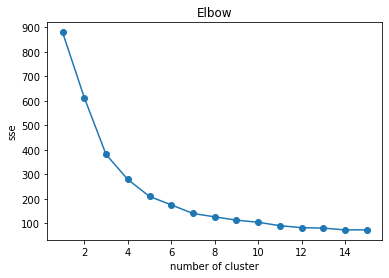

In [45]:
q10.elbow_func(data_pca_std)

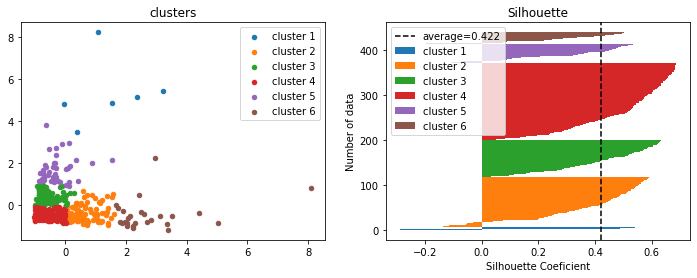

In [46]:
q10.plot_silhouette(data_pca_std, q10_pred)

### 【解答】

エルボー法やシルエット分析では6~10あたりのクラスタ数が良さげに見えるが、今回のデータから分析できる課題は、

* 今後の販売方針(チャネルごとや地域ごとに何を売っていくか？など)
* 現状分析を行って、無駄を省く(例：HoReCaではDetergents_Paperなどが弱めなので、そこを強化するのか？もしくは事業整理するのか？など)

などが考えられる。

それらの課題を解決するために、例えば分割したクラスタごとに価格や科目、地域の比率を見たりすれば何かしらのアイディアが得られるかもしれない。

そのため、クラスタ数を増やすことに意味はあまり感じられない。よって、今回は

* チャネル2、地域3
* 科目分類が6

というデータであることから、クラスタ数も6が良いのではないか？と考える。もしくは次の公倍数の12？

ひとまず一旦6でやってみて、様子をみたい。

# 【問題11】既知のグループとの比較
RegionとChannelはK-meansに使用しなかったが、これらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

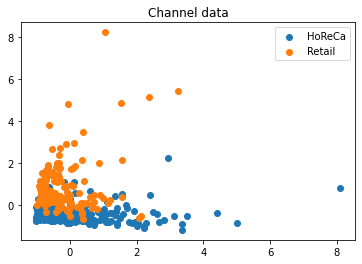

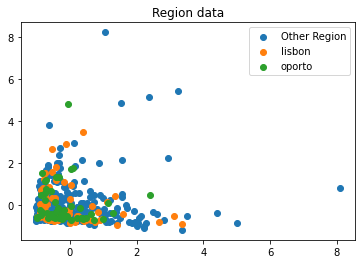

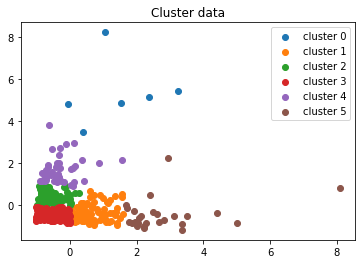

In [47]:
# チャネルごとにプロット
plt.title("Channel data")
plt.scatter(data_pca_std[raw_data.Channel == 1][:,0], data_pca_std[raw_data.Channel == 1][:,1], label='HoReCa')
plt.scatter(data_pca_std[raw_data.Channel == 2][:,0], data_pca_std[raw_data.Channel == 2][:,1], label='Retail')
plt.legend()
plt.show()

# 地域ごとにプロット
plt.title("Region data")
plt.scatter(data_pca_std[raw_data.Region == 3][:,0], data_pca_std[raw_data.Region == 3][:,1], label='Other Region')
plt.scatter(data_pca_std[raw_data.Region == 1][:,0], data_pca_std[raw_data.Region == 1][:,1], label='lisbon')
plt.scatter(data_pca_std[raw_data.Region == 2][:,0], data_pca_std[raw_data.Region == 2][:,1], label='oporto')
plt.legend()
plt.show()

# クラスターごとにプロット
plt.title("Cluster data")
plt.scatter(data_pca_std[q10_pred == 0][:,0], data_pca_std[q10_pred == 0][:,1], label='cluster 0')
plt.scatter(data_pca_std[q10_pred == 1][:,0], data_pca_std[q10_pred == 1][:,1], label='cluster 1')
plt.scatter(data_pca_std[q10_pred == 2][:,0], data_pca_std[q10_pred == 2][:,1], label='cluster 2')
plt.scatter(data_pca_std[q10_pred == 3][:,0], data_pca_std[q10_pred == 3][:,1], label='cluster 3')
plt.scatter(data_pca_std[q10_pred == 4][:,0], data_pca_std[q10_pred == 4][:,1], label='cluster 4')
plt.scatter(data_pca_std[q10_pred == 5][:,0], data_pca_std[q10_pred == 5][:,1], label='cluster 5')
plt.legend()
plt.show()


* Channel : 小売店の形態、1=HoReCa。食品サービス業界。Hotel/Restaurant/Cafeの略称、2=その他 
* Region : 消費地域 - 1=リスボン、2=ポルト、3=その他
* Cluster : 近しいデータごとに分類したもの。

ChannelとRegionはデータ元の分類だが、クラスタはデータを分析して分類した結果。

# 【問題12】卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめてください。


《ヒント》


前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。


条件ごとにデータを見る際にはPandasのgroupbyが便利です。


[pandas.DataFrame.groupby — pandas 0.23.4 documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html)

### 元データの概観をチェック

In [48]:
# 元データにクラスタ列を追加
raw_data["cluster"] = q10_pred
raw_data

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,2,3,12669,9656,7561,214,2674,1338,2
1,2,3,7057,9810,9568,1762,3293,1776,2
2,2,3,6353,8808,7684,2405,3516,7844,2
3,1,3,13265,1196,4221,6404,507,1788,1
4,2,3,22615,5410,7198,3915,1777,5185,1
...,...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204,1
436,1,3,39228,1431,764,4510,93,2346,5
437,2,3,14531,15488,30243,437,14841,1867,4
438,1,3,10290,1981,2232,1038,168,2125,3


In [49]:
display(raw_data.groupby("cluster").mean())
raw_data.groupby("cluster").size()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
cluster,,,,,,,,
0,2.000000,2.500000,23355.666667,40938.166667,57842.500000,2986.000000,28213.500000,2735.666667
1,1.198198,2.558559,20326.531532,3689.657658,5047.459459,4022.063063,1093.864865,1678.360360
2,1.726190,2.619048,4335.523810,7705.178571,10986.452381,1325.440476,4693.464286,1417.119048
3,1.058824,2.500000,6024.923529,2316.435294,2898.317647,2643.729412,670.811765,842.811765
4,1.953488,2.418605,6028.093023,15615.069767,23558.558140,1901.976744,10333.651163,2218.860465
5,1.076923,2.730769,47543.192308,7026.884615,6255.576923,9412.653846,943.115385,4250.153846


cluster
0      6
1    111
2     84
3    170
4     43
5     26
dtype: int64

In [120]:
# Channel==1のデータ
display(raw_data[raw_data.Channel == 1].describe())
display(raw_data[raw_data.Channel == 2].describe())

# Cluster==1のデータ
display(raw_data[q10_pred == 1].describe())

# Cluster==3のデータ
display(raw_data[q10_pred == 3].describe())

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
count,298.0,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,1.0,2.510067,13475.560403,3451.724832,3962.137584,3748.251678,790.560403,1415.956376,2.493289
std,0.0,0.805013,13831.687502,4352.165571,3545.513391,5643.912500,1104.093673,3147.426922,1.161223
min,1.0,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000,1.000000
25%,1.0,2.000000,4070.250000,1164.500000,1703.750000,830.000000,183.250000,379.000000,1.000000
50%,1.0,3.000000,9581.500000,2157.000000,2684.000000,2057.500000,385.500000,821.000000,3.000000
75%,1.0,3.000000,18274.750000,4029.500000,5076.750000,4558.750000,899.500000,1548.000000,3.000000
max,1.0,3.000000,112151.000000,43950.000000,21042.000000,60869.000000,6907.000000,47943.000000,5.000000


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
count,142.0,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
mean,2.0,2.612676,8904.323944,10716.500000,16322.852113,1652.612676,7269.507042,1753.436620,2.450704
std,0.0,0.703069,8987.714750,9679.631351,12267.318094,1812.803662,6291.089697,1953.797047,1.217936
min,2.0,1.000000,18.000000,928.000000,2743.000000,33.000000,332.000000,3.000000,0.000000
25%,2.0,2.000000,2347.750000,5938.000000,9245.250000,534.250000,3683.500000,566.750000,2.000000
50%,2.0,3.000000,5993.500000,7812.000000,12390.000000,1081.000000,5614.500000,1350.000000,2.000000
75%,2.0,3.000000,12229.750000,12162.750000,20183.500000,2146.750000,8662.500000,2156.000000,4.000000
max,2.0,3.000000,44466.000000,73498.000000,92780.000000,11559.000000,40827.000000,16523.000000,5.000000


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.00000,111.0
mean,1.198198,2.558559,20326.531532,3689.657658,5047.459459,4022.063063,1093.864865,1678.36036,1.0
std,0.400450,0.759003,5292.084456,2840.030648,4032.202666,4776.130831,1368.513204,1793.03515,0.0
min,1.000000,1.000000,11243.000000,134.000000,3.000000,118.000000,3.000000,57.00000,1.0
25%,1.000000,2.000000,16576.500000,1462.000000,2095.000000,948.500000,229.000000,606.00000,1.0
50%,1.000000,3.000000,19046.000000,2801.000000,3643.000000,2436.000000,483.000000,1136.00000,1.0
75%,1.000000,3.000000,24339.000000,5074.500000,7002.500000,5204.000000,1401.500000,2186.00000,1.0
max,2.000000,3.000000,31812.000000,13252.000000,21042.000000,35009.000000,6707.000000,14472.00000,1.0


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.0
mean,1.058824,2.500000,6024.923529,2316.435294,2898.317647,2643.729412,670.811765,842.811765,3.0
std,0.235989,0.801256,3774.363571,1797.860039,1858.857960,3126.991022,872.554022,851.761919,0.0
min,1.000000,1.000000,3.000000,55.000000,137.000000,47.000000,3.000000,3.000000,3.0
25%,1.000000,2.000000,2727.750000,1000.750000,1526.250000,775.250000,179.750000,311.000000,3.0
50%,1.000000,3.000000,5995.500000,1790.500000,2340.500000,1470.000000,315.000000,622.500000,3.0
75%,1.000000,3.000000,9183.500000,3255.000000,4029.750000,3448.250000,820.750000,1095.000000,3.0
max,2.000000,3.000000,13624.000000,9250.000000,7854.000000,17866.000000,4762.000000,5137.000000,3.0


In [83]:
grouped = raw_data.groupby('Channel')
display(grouped.describe())
print(grouped.size)

Region                                               Fresh  \
         count      mean       std  min  25%  50%  75%  max  count   
Channel                                                              
1        298.0  2.510067  0.805013  1.0  2.0  3.0  3.0  3.0  298.0   
2        142.0  2.612676  0.703069  1.0  2.0  3.0  3.0  3.0  142.0   

                       ... Delicassen          cluster                      \
                 mean  ...        75%      max   count      mean       std   
Channel                ...                                                   
1        13475.560403  ...     1548.0  47943.0   298.0  2.493289  1.161223   
2         8904.323944  ...     2156.0  16523.0   142.0  2.450704  1.217936   

                                  
         min  25%  50%  75%  max  
Channel                           
1        1.0  1.0  3.0  3.0  5.0  
2        0.0  2.0  2.0  4.0  5.0  

[2 rows x 64 columns]

<bound method GroupBy.size of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x7fa77a7bc9d0>>


In [72]:
grouped_region = raw_data.groupby('Region')
display(grouped_region.describe())

Channel                                               Fresh  \
         count      mean       std  min  25%  50%  75%  max  count   
Region                                                               
1         77.0  1.233766  0.426000  1.0  1.0  1.0  1.0  2.0   77.0   
2         47.0  1.404255  0.496053  1.0  1.0  1.0  2.0  2.0   47.0   
3        316.0  1.332278  0.471777  1.0  1.0  1.0  2.0  2.0  316.0   

                      ... Delicassen          cluster                      \
                mean  ...        75%      max   count      mean       std   
Region                ...                                                   
1       11101.727273  ...    1775.00   6854.0    77.0  2.519481  1.131026   
2        9887.680851  ...    1538.50   5609.0    47.0  2.446809  1.176001   
3       12533.471519  ...    1832.75  47943.0   316.0  2.474684  1.193631   

                                 
        min  25%  50%  75%  max  
Region                           
1       0.0  2.0  3.0  3.0  5.0  
2       0.0  1.0  3.0  3.0  5.0  
3       0.0  1.0  3.0  3.0  5.0  

[3 rows x 64 columns]

In [117]:
pd.set_option('display.max_columns', 100)
grouped_all = raw_data.groupby(['Channel','Region','cluster'])
display(grouped_all.describe().T)

Channel                            1                                       \
Region                             1                                        
cluster                            1             2             3        4   
Fresh            count     17.000000      7.000000     31.000000      1.0   
                 mean   21698.823529   4422.571429   6409.838710   5909.0   
                 std     5541.526169   3241.037687   3744.778463      NaN   
                 min    14755.000000    514.000000    583.000000   5909.0   
                 25%    18044.000000   2575.000000   2672.000000   5909.0   
                 50%    20893.000000   3317.000000   7274.000000   5909.0   
                 75%    25203.000000   5799.000000   8770.500000   5909.0   
                 max    31614.000000  10379.000000  13569.000000   5909.0   
Milk             count     17.000000      7.000000     31.000000      1.0   
                 mean    3170.705882   9945.428571   2232.451613  23527.0   
                 std     3124.283793   3875.590573   1690.207164      NaN   
                 min      258.000000   6602.000000    346.000000  23527.0   
                 25%     1222.000000   7639.000000    855.500000  23527.0   
                 50%     1801.000000   8323.000000   1931.000000  23527.0   
                 75%     3838.000000  10721.500000   3409.500000  23527.0   
                 max    11487.000000  17972.000000   6380.000000  23527.0   
Grocery          count     17.000000      7.000000     31.000000      1.0   
                 mean    3891.764706   8472.428571   2746.354839  13699.0   
                 std     4071.061709   4097.834748   1830.435933      NaN   
                 min      593.000000   3828.000000    489.000000  13699.0   
                 25%     1495.000000   5804.500000   1531.000000  13699.0   
                 50%     2475.000000   6869.000000   2112.000000  13699.0   
                 75%     3838.000000  10731.500000   3736.500000  13699.0   
                 max    16966.000000  15538.000000   6824.000000  13699.0   
Frozen           count     17.000000      7.000000     31.000000      1.0   
                 mean    4029.529412   1518.714286   2598.290323  10155.0   
                 std     4583.110913   1484.676925   2366.272500      NaN   
                 min      432.000000     91.000000    327.000000  10155.0   
                 25%     1765.000000    856.000000    907.500000  10155.0   
                 50%     2532.000000   1329.000000   1730.000000  10155.0   
                 75%     4260.000000   1406.500000   3925.500000  10155.0   
                 max    18711.000000   4686.000000   7683.000000  10155.0   
Detergents_Paper count     17.000000      7.000000     31.000000      1.0   
                 mean     352.352941   2900.714286    852.612903    830.0   
                 std      216.172657   1951.608458   1186.472129      NaN   
                 min       28.000000     93.000000      5.000000    830.0   
                 25%      244.000000   1556.500000    201.000000    830.0   
                 50%      333.000000   3143.000000    402.000000    830.0   
                 75%      429.000000   4064.000000    849.000000    830.0   
                 max      763.000000   5828.000000   4762.000000    830.0   
Delicassen       count     17.000000      7.000000     31.000000      1.0   
                 mean    1741.352941   1515.285714    657.870968   3636.0   
                 std     1639.928350   1082.133651    571.186528      NaN   
                 min      204.000000    239.000000      7.000000   3636.0   
                 25%      655.000000    765.000000    286.000000   3636.0   
                 50%     1158.000000   1215.000000    548.000000   3636.0   
                 75%     2563.000000   2179.000000    796.000000   3636.0   
                 max     6854.000000   3265.000000   2398.000000   3636.0   

Channel                                                                 

In [118]:
display(grouped_all.std())

Fresh          Milk       Grocery       Frozen  \
Channel Region cluster                                                          
1       1      1         5541.526169   3124.283793   4071.061709  4583.110913   
               2         3241.037687   3875.590573   4097.834748  1484.676925   
               3         3744.778463   1690.207164   1830.435933  2366.272500   
               4                 NaN           NaN           NaN          NaN   
               5         4372.221556   1282.087881   2663.212909  1731.834384   
        2      1         5255.395137    929.992497   3307.169856  2133.768656   
               3         4027.309686    855.799549   1954.702176  4544.744393   
               5                 NaN           NaN           NaN          NaN   
        3      1         5518.802762   2632.600174   3368.872973  5498.109842   
               2         4045.248187   3820.087581   3580.585464  2189.956551   
               3         3699.844046   1860.800728   1625.464728  3049.270337   
               4                 NaN           NaN           NaN          NaN   
               5        18918.975194  10983.617255   5534.472784  8697.948750   
2       1      0                 NaN           NaN           NaN          NaN   
               1                 NaN           NaN           NaN          NaN   
               2         1138.156653   1641.101541   3569.772747  1030.904393   
               3         5856.258362   2448.003676    247.487373  1915.552270   
               4         3614.794155   4634.857678   6691.976516  2195.880559   
        2      0                 NaN           NaN           NaN          NaN   
               1         6034.203372   3247.024843   4030.339068  6047.734314   
               2         2245.110844   4837.145632   1900.692996   229.171042   
               3          354.967604    920.653029   1238.851081   733.976839   
               4         4315.778796   7274.206908   4426.186465   422.063751   
        3      0        12744.805595  15078.394839  24979.551963  3194.045750   
               1         4656.735516   2305.681590   3103.136042  1881.501755   
               2         4056.008652   2558.950682   3346.901136  1291.784764   
               3         2066.304213   2375.071339   1333.453474   596.747741   
               4         6878.342361   7555.726681   6453.705009  1316.750090   
               5          736.805266     19.798990    651.245345   588.312842   

                        Detergents_Paper    Delicassen  
Channel Region cluster                                  
1       1      1              216.172657   1639.928350  
               2             1951.608458   1082.133651  
               3             1186.472129    571.186528  
               4                     NaN           NaN  
               5              119.089602   1255.976247  
        2      1              561.710523    758.278137  
               3              253.219781    481.945391  
               5                     NaN           NaN  
        3      1              750.735598   2032.057558  
               2             1989.919570   1133.115600  
               3              561.290051    965.931776  
               4                     NaN           NaN  
               5             1109.125454  10703.020978  
2       1      0                     NaN           NaN  
               1                     NaN           NaN  
               2             1629.725795   2255.735061  
               3              118.086832    549.421969  
               4             4444.364166   1567.103464  
        2      0                     NaN           NaN  
               1             1906.538836    819.118022  
               2             2334.239184   1269.841526  
               3             1063.488599    195.868578  
               4             3533.786186    821.779921  
        3      0             9013.917586   2404.578879  
               1             1499.202

In [101]:
display(grouped["Fresh"].mean().T)
display(grouped["Milk"].mean().T)
display(grouped["Grocery"].mean().T)
display(grouped["Frozen"].mean().T)
display(grouped["Detergents_Paper"].mean().T)
display(grouped["Delicassen"].mean().T)

display(grouped_region["Fresh"].mean().T)
display(grouped_region["Milk"].mean().T)
display(grouped_region["Grocery"].mean().T)
display(grouped_region["Frozen"].mean().T)
display(grouped_region["Detergents_Paper"].mean().T)
display(grouped_region["Delicassen"].mean().T)


display(grouped_cluster["Channel"].mean().T)
display(grouped_cluster["Region"].mean().T)
display(grouped_cluster["Fresh"].mean().T)
display(grouped_cluster["Milk"].mean().T)
display(grouped_cluster["Grocery"].mean().T)
display(grouped_cluster["Frozen"].mean().T)
display(grouped_cluster["Detergents_Paper"].mean().T)
display(grouped_cluster["Delicassen"].mean().T)

Channel
1    13475.560403
2     8904.323944
Name: Fresh, dtype: float64

Channel
1     3451.724832
2    10716.500000
Name: Milk, dtype: float64

Channel
1     3962.137584
2    16322.852113
Name: Grocery, dtype: float64

Channel
1    3748.251678
2    1652.612676
Name: Frozen, dtype: float64

Channel
1     790.560403
2    7269.507042
Name: Detergents_Paper, dtype: float64

Channel
1    1415.956376
2    1753.436620
Name: Delicassen, dtype: float64

Region
1    11101.727273
2     9887.680851
3    12533.471519
Name: Fresh, dtype: float64

Region
1    5486.415584
2    5088.170213
3    5977.085443
Name: Milk, dtype: float64

Region
1    7403.077922
2    9218.595745
3    7896.363924
Name: Grocery, dtype: float64

Region
1    3000.337662
2    4045.361702
3    2944.594937
Name: Frozen, dtype: float64

Region
1    2651.116883
2    3687.468085
3    2817.753165
Name: Detergents_Paper, dtype: float64

Region
1    1354.896104
2    1159.702128
3    1620.601266
Name: Delicassen, dtype: float64

cluster
0    2.000000
1    1.198198
2    1.726190
3    1.058824
4    1.953488
5    1.076923
Name: Channel, dtype: float64

cluster
0    2.500000
1    2.558559
2    2.619048
3    2.500000
4    2.418605
5    2.730769
Name: Region, dtype: float64

cluster
0    23355.666667
1    20326.531532
2     4335.523810
3     6024.923529
4     6028.093023
5    47543.192308
Name: Fresh, dtype: float64

cluster
0    40938.166667
1     3689.657658
2     7705.178571
3     2316.435294
4    15615.069767
5     7026.884615
Name: Milk, dtype: float64

cluster
0    57842.500000
1     5047.459459
2    10986.452381
3     2898.317647
4    23558.558140
5     6255.576923
Name: Grocery, dtype: float64

cluster
0    2986.000000
1    4022.063063
2    1325.440476
3    2643.729412
4    1901.976744
5    9412.653846
Name: Frozen, dtype: float64

cluster
0    28213.500000
1     1093.864865
2     4693.464286
3      670.811765
4    10333.651163
5      943.115385
Name: Detergents_Paper, dtype: float64

cluster
0    2735.666667
1    1678.360360
2    1417.119048
3     842.811765
4    2218.860465
5    4250.153846
Name: Delicassen, dtype: float64

__チャンネルごとの差異__

一件当たりの単価

channel1:HoReCa

channel2: Retail

* Fresh 1 > 2
* Milk 1 < 2 
* Grocery 1 < 2
* Frozen 1 > 2
* Detergents_Paper 1 < 2
* Delicassen 1 <= 2


* MilkはRetailの方が、取引先あたりの卸売額が大きい傾向がある
* GroceryはRetailの方が、取引先あたりの卸売額が大きい傾向がある
* FrozenはHorecaの方が、取引先あたりの卸売額が大きい傾向がある
* 洗剤、紙製品はRetailの方が、取引先あたりの卸売額が大きい傾向がある
* Horecaは、Retailに対して倍近い取引があるにもかかわらず、卸売額はそれほど大きな差がない


__地域ごとの差異__

一件当たりの単価

Region1:リスボン

Region2:ポルト

Region3:その他

* Fresh 3 > 1 > 2
* Milk 3 > 1 > 2 
* Grocery 2 > 3 > 1
* Frozen 2 > 1 > 3
* Detergents_Paper 2 > 3 > 1
* Delicassen 3 > 1 > 2


* RegionごとではOther Region方が、取引先あたりの卸売額が大きい傾向がある
* ポルトの顧客はGroceryやFrozen、Detergents_Paperの取引量が多い。一人暮らし向けが多い？



Freshで最も販売額中央値が高く、顧客数とのバランスも良いのが
* Retail - Lisbon - cluster3
または
* Retail - Oporto - cluster4


Milkで最も販売額中央値が高く、顧客数とのバランスも良いのが
* HoReCa - Lisbon - cluster2
または
* Retail - Oporto - cluster4


Groceryで最も販売額中央値が高く、顧客数とのバランスも良いのが
* HoReCa - Lisbon - cluster1
または
* Retail - Other - cluster4


Frozenで最も販売額中央値が高く、顧客数とのバランスも良いのが
* HoReCa - Other - cluster1
または
* Retail - Oporto - cluster1


Detergents_Paperで最も販売額中央値が高く、顧客数とのバランスも良いのが
* Retail - Lisbon - cluster4
または
* Retail - Other - cluster4


Delicassenで最も販売額中央値が高く、顧客数とのバランスも良いのが
* Retail - Lisbon - cluster2
または
* Retail - Other - cluster4


### データまとめ

以上の観点から、最も客単価が高く効率よく売れているのは、
* Channel2
* Cluster4
に属する取引先だと考えられる。

企業戦略としてはここを得意先と仮定し、売れ筋商品を推していくべき。
もしくはCluster4に属しているが若干弱めな、OportoのFrozen及びDelicassenあたりを強化していくのが良いか。

念のためCluster4のデータをみてみる。

In [123]:
# Cluster==4のデータ
display(raw_data[q10_pred == 4].describe())

# 全データ
display(raw_data.describe())

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.0
mean,1.953488,2.418605,6028.093023,15615.069767,23558.558140,1901.976744,10333.651163,2218.860465,4.0
std,0.213083,0.823250,5859.784454,6986.657554,6444.884735,1939.237952,4944.023761,2802.844249,0.0
min,1.000000,1.000000,85.000000,3737.000000,13567.000000,33.000000,282.000000,3.000000,4.0
25%,2.000000,2.000000,1547.500000,11094.000000,19632.500000,796.000000,7230.500000,704.000000,4.0
50%,2.000000,3.000000,4967.000000,14069.000000,22019.000000,1274.000000,9606.000000,1423.000000,4.0
75%,2.000000,3.000000,8280.000000,20807.000000,26852.500000,2294.000000,12973.000000,2486.500000,4.0
max,2.000000,3.000000,26373.000000,36423.000000,45828.000000,10155.000000,24231.000000,16523.000000,4.0


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455,2.479545
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937,1.178602
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000,0.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000,1.000000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000,3.000000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000,3.000000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000,5.000000


件数は若干少ないが、平均的に良い販売実績。
ちょっとFreshとFrozenが弱いか？
ここを伸ばせればもっと成績上がるかも？